# Italian Politicians Network Analysis
We know that politicians in social networks tend to have thousands, sometimes millions, of followers and that they may act as megaphones for their causes via the echo chambers mechanic. We pay, however, way less attention on people ***followed by*** politicians on social networks: who does one leader follow? What does he/she speak about in their feed? Are one politician's followers followed by other politicians?  

The goal of this Notebook is to briefly analyze the network data from the italian party leaders in the political elections coming in September, 2022.   
In fact, we will look at the network of their ***friends***, which are the accounts followed by a user, and see what information can be extracted from it.  
Subjects covered in this Notebook are:
* distinction between **friends** and **followers** according to Twitter;
* **plotting** data in network form;
* **network topology**, measures of centrality and other metrics:
* **communities** visualization.

## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import community
import matplotlib.pyplot as plt

c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Drawing Functions

In [54]:
def draw_graph(G, pos_nodes, relevant_nodes=[], node_size=3, relevant_node_size=100, node_color='blue', communities={}):
    """
        Draws a Graph and highlights relevant nodes in it.

    :param G: graph data;
    :param pos_nodes: nodes position in graph (layout);
    :param list relevant_nodes: relevant nodes to highlight in the network, default to an empty list;
    :param float node_size: size of every node in the network, default to 50 but can also be a list;
    :param float relevant_node_size: size of nodes to highlight in the network, defaults to 100 but can also be a list;
    :param list node_color: color of nodes that are NON relevant;
    :param dict communities: dictionary of communities in the network.
    
    """
    node_labels = {}
    for node in G.nodes():
        if node in relevant_nodes:
            #set the node name as the key and the label as its value 
            node_labels[node] = node
    plt.figure(figsize=(15, 10))
    # set the argument 'with labels' to False so you have unlabeled graph
    nx.draw_networkx(G, pos_nodes, with_labels=False, node_size=node_size, edge_color='grey', cmap=plt.get_cmap("Blues"), node_color=node_color)

    if communities == {}: # no communities
        # draw relevant nodes
        nx.draw_networkx_nodes(G, pos_nodes, nodelist=relevant_nodes, node_size=relevant_node_size, node_color='r', alpha=0.5)
        # only add labels to the nodes you require
        nx.draw_networkx_labels(G, pos_nodes, node_labels, font_size=16, font_color='r', font_weight='bold')
    else:
        # draw relevant nodes
        nx.draw_networkx_nodes(G, pos_nodes, nodelist=relevant_nodes, node_size=relevant_node_size, node_color=[communities.get(node)for node in relevant_nodes], alpha=0.5)
        # only add labels to the nodes you require
        nx.draw_networkx_labels(G, pos_nodes, node_labels, font_size=15, font_color='darkred', font_weight='bold')

    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])

In [57]:
def draw_metric(G, dct, spring_pos, node_color='blue'):
  """   
    draw the graph G using the layout spring_pos.
    The top 10 nodes w.r.t. values in the dictionary dct
    are enhanced in the visualization 
  """
  top = 10
  max_nodes =  sorted(dct.items(), key = lambda v: -v[1])[:top]
  max_keys = [key for key,_ in max_nodes]
  max_vals = [val*300 for _, val in max_nodes]
  node_labels = {}
  for node in G.nodes():
      if node in max_keys:
          #set the node name as the key and the label as its value 
          node_labels[node] = node

  plt.figure(figsize=(12, 9))
  # set the argument 'with labels' to False so you have unlabeled graph
  nx.draw_networkx(G, spring_pos, with_labels=False, node_size=5, edge_color='grey', cmap=plt.get_cmap("Blues"), node_color=node_color)
  # draw relevant nodes
  nx.draw_networkx_nodes(G, pos=spring_pos, nodelist=max_keys, node_color='darkred', node_size=max_vals)
  # only add labels to the nodes you require
  nx.draw_networkx_labels(G, spring_pos, labels=node_labels, font_size=15, font_color='darkred', font_weight='bold')
  plt.axis('off')
  axis = plt.gca()
  axis.set_xlim([1.2*x for x in axis.get_xlim()])
  axis.set_ylim([1.2*y for y in axis.get_ylim()])

## Dataset Overview

For this analysis, we will load a dataset made of connections of various political leaders that will be present in September 2022 elections.  
In particular, we are talking about the leaders of the Center-Right Coalition (Giorgia Meloni, Matteo Salvini, Silvio Berlusconi) as well as of the Center-Left Coalition (Enrico Letta, Emma Bonino, Nicola Fratoianni, Pippo Civati, Angelo Bonelli, Luigi Di Maio). We also tracked connections of the leaders of the Third Pole (Carlo Calenda, Matteo Renzi) and of the 5 Stars Movement (Giuseppe Conte).


In [4]:
political_net = pd.read_csv('data/politicians_network.csv')
political_net = political_net[['source', 'target']]
political_net.shape

(28421, 2)

In [5]:
politicians = list(political_net['source'].unique())
politicians

['GiuseppeConteIT',
 'luigidimaio',
 'matteorenzi',
 'GiorgiaMeloni',
 'matteosalvinimi',
 'CarloCalenda',
 'berlusconi',
 'NFratoianni',
 'AngeloBonelli1',
 'emmabonino',
 'civati',
 'EnricoLetta']

Data was collected via the ***tweepy*** library that allows us to interact with the Twitter API and make requests to it directly from Python.  
Here, we just load the data which were previously downloaded, for the sake of brevity (downloading a user's friends/followers list might be very time consuming depending on the number of calls that has to be made). 

Note that we refer to "***friends***" as the Twitter users that a specific user follows (e.g., following) and to "***followers***" as the Twitter accounts that follow a specific user.  
In this DF, the "*source*" column represents users and the "*target*" column represents a profile followed by a particular user. 



In [6]:
political_net

,source,target
0,GiuseppeConteIT,Dani_Rondinelli
1,GiuseppeConteIT,tomasomontanari
2,GiuseppeConteIT,ScuolaM5S
3,GiuseppeConteIT,LauraBottici
4,GiuseppeConteIT,virginiaraggi
...,...,...
28416,EnricoLetta,tizianotaiti
28417,EnricoLetta,strabene
28418,EnricoLetta,valentinoben
28419,EnricoLetta,MassimoPeron


We also load some additional information, also downloaded via tweepy. These informations include, for each politician in the previous list, the number of statuses (tweets) they made, their friend count (which are people followed by the user) and their follower count (which are the profiles following the user). We can also see the age of the account (in days) and the average number of tweets per day, since the creation of the account.  
In this notebook we will actually make use only of the number of followers, for visualization purposes

In [7]:
add_info = pd.DataFrame(pd.read_csv('data/additional_info_politics.csv'))
add_info

,screen_name,description,statuses_count,friends_count,followers_count,account_age_days,average_tweets
0,EnricoLetta,"Segretario del Partito Democratico @pdnetwork,...",18279,14104,722299,3949,4.63
1,GiuseppeConteIT,Giurista e Avvocato. Professore ordinario di d...,2291,138,1134921,1575,1.45
2,luigidimaio,Ministro degli Affari Esteri e della Cooperazi...,7185,331,776440,4838,1.49
3,matteorenzi,Senatore di Firenze - @ItaliaViva,14040,979,3373484,4998,2.81
4,GiorgiaMeloni,"Romana, classe '77. Politica e giornalista. Se...",19702,927,1272567,4544,4.34
5,matteosalvinimi,Leader della Lega #25settembrevotoLega 🇮🇹,54047,2007,1495439,4194,12.89
6,CarloCalenda,"@Azione_it - ""Un uomo che non si interessa del...",34893,162,409522,3093,11.28
7,berlusconi,Presidente Forza Italia. Eurodeputato Gruppo d...,5270,67,224332,1794,2.94
8,civati,NaN,57335,6375,409241,5303,10.81
9,NFratoianni,"segretario nazionale di Sinistra Italiana, dom...",62943,2014,65863,3941,15.97


How many **friends** does every leader has? Nay, how many people ***are followed*** by said leader?

In [8]:
# how many profiles are followed by each politician?
for p in politicians:
    print(p, 'follows',len(political_net[political_net['source']==p]['target']), 'profiles')

GiuseppeConteIT follows 143 profiles
luigidimaio follows 331 profiles
matteorenzi follows 980 profiles
GiorgiaMeloni follows 930 profiles
matteosalvinimi follows 2010 profiles
CarloCalenda follows 163 profiles
berlusconi follows 67 profiles
NFratoianni follows 2016 profiles
AngeloBonelli1 follows 862 profiles
emmabonino follows 340 profiles
civati follows 6376 profiles
EnricoLetta follows 14203 profiles


How many **followers** does every leader have?

In [9]:
followers_friends_ratio = {}
for p in politicians:
    followers_friends_ratio[p] = (int(add_info[add_info['screen_name']==p]['followers_count'].values))/(int(add_info[add_info['screen_name']==p]['friends_count'].values))
    print(p, 'has', int(add_info[add_info['screen_name']==p]['followers_count'].values), 'followers')
ff_ratio = list(followers_friends_ratio.values())    

GiuseppeConteIT has 1134921 followers
luigidimaio has 776440 followers
matteorenzi has 3373484 followers
GiorgiaMeloni has 1272567 followers
matteosalvinimi has 1495439 followers
CarloCalenda has 409522 followers
berlusconi has 224332 followers
NFratoianni has 65863 followers
AngeloBonelli1 has 9864 followers
emmabonino has 241248 followers
civati has 409241 followers
EnricoLetta has 722299 followers


## Network Topology & Community Detection

The next step is to visualize this information in network form and to do this, we will employ the **networkx** Python library.  

First, we create a graph, G, directly from the dataframe of source-target pairs. In this graph (network), each instance represents an ***edge***, which is the connection between ***nodes*** in the graph; nodes are represented by the users and the profile they follow.

In [10]:
G = nx.from_pandas_edgelist(df=political_net ,source='source',target='target', edge_attr=None, create_using=nx.Graph())
print(nx.info(G))

Graph with 24192 nodes and 28302 edges


C:\Users\Dylan\AppData\Local\Temp/ipykernel_10416/1424420976.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


Now we are also able to know **how many connections are shared** between each pair of political leaders looking at their common neighbors (users that share a connection between two nodes)

In [11]:
for pair in itertools.combinations(politicians, 2):
    print(pair[0], 'and', pair[1], 'have', len(sorted(nx.common_neighbors(G, u=pair[0], v=pair[1]))),'common friends')

GiuseppeConteIT and luigidimaio have 26 common friends
GiuseppeConteIT and matteorenzi have 24 common friends
GiuseppeConteIT and GiorgiaMeloni have 24 common friends
GiuseppeConteIT and matteosalvinimi have 22 common friends
GiuseppeConteIT and CarloCalenda have 10 common friends
GiuseppeConteIT and berlusconi have 1 common friends
GiuseppeConteIT and NFratoianni have 25 common friends
GiuseppeConteIT and AngeloBonelli1 have 15 common friends
GiuseppeConteIT and emmabonino have 20 common friends
GiuseppeConteIT and civati have 14 common friends
GiuseppeConteIT and EnricoLetta have 66 common friends
luigidimaio and matteorenzi have 40 common friends
luigidimaio and GiorgiaMeloni have 45 common friends
luigidimaio and matteosalvinimi have 29 common friends
luigidimaio and CarloCalenda have 12 common friends
luigidimaio and berlusconi have 1 common friends
luigidimaio and NFratoianni have 64 common friends
luigidimaio and AngeloBonelli1 have 39 common friends
luigidimaio and emmabonino h

Understanding the ***topology*** of a network, as well as the role of its nodes is a crucial step in the analysis of social networks.  

Keep in mind that in this context, each node is actually a Twitter account, and that the links we collected are there because a politician in the original list follows a subset of these accounts.  

We begin our analysis trying to visualize the network and the ***communities*** that it contains: in doing so, we make use of the *best_partition()* function from the *community* package that refers to *python-louvain* (on pypi). This function computes the partition of the graph nodes which maximizes (tries to maximize) the modularity using the Louvain heuristics. 


In [60]:
communities = community.best_partition(G)
values = [communities.get(node) for node in G.nodes()]

In [12]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G)

To get a first look at our network, we will draw each connection (edge) in grey and each user (node) according to a map of blues depending on their community; also, we choose to draw the nodes representing the politicians in the list with a red label and a specific size: in this plot in fact, **each politician's node size is represented as the ratio between the user's follower count and their friend count**.

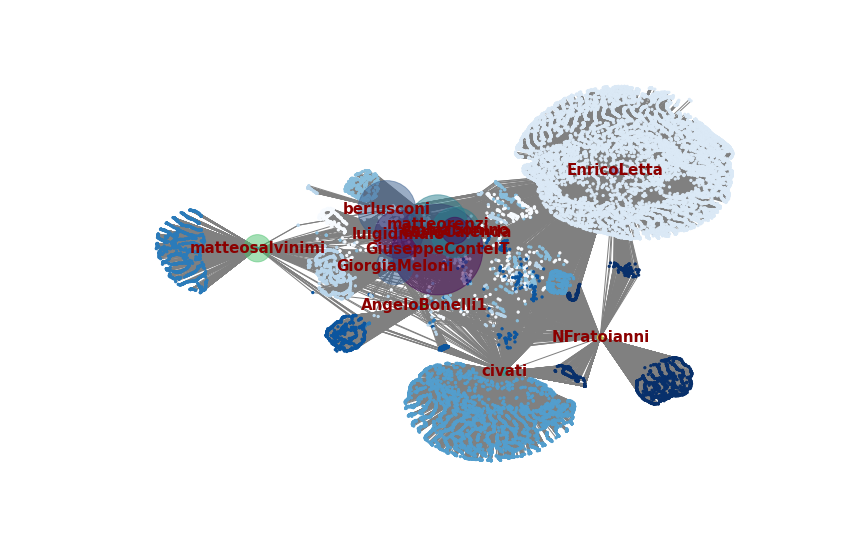

In [61]:
draw_graph(G, pos_nodes=spring_pos, relevant_nodes=politicians, node_size=5, relevant_node_size=ff_ratio, node_color=values, communities=communities)

We can already draw some conclusions about italian politics from the visualization of our data.  

First, There are many nodes in the center of the graph, which represents Twitter accounts followed by more than one politician: that is to say, **political party leaders have many friends in common**, at least as Twitter "friendship" goes.  
Second, each politician has its own community of friends, accounts followed uniquely by him/her that aren't shared with the other leaders. This is only natural and may reflect differences in interests between political leaders: you usually follow accounts that speak about subjects that interests you; further, it is typical on Twitter to "***radicalise***", to follow and listen to only members of your "***bubble***" or echo-chamber.
Third, it is interesting to look at the layout of the network: members of the "*mainstream*" politics such as Berlusconi, Letta, Renzi and Conte (who all have been Prime Ministers), as well as Calenda, Bonino and Di Maio (who all covered institutional roles in the past) occupy the center of the graph and share many connections between each other. More interestingly, as a confirmation of the radicalization theory, members of ***non-mainstream politics*** are divided in the graph by their political identity: Salvini (head of the League) and Meloni (President of Brothers of Italy), both members of the Right coalition for September's elections, are located on one side of the graph, sharing some neighbors with each other as well as many contacts with Berlusconi (another member of their coalition and President of Forza Italia) and the rest of the political mainstream. On the other side of the network Bonelli (Greens), Civati (Possible) and Fratoianni (Italian Left), members of the Left coalition share very few connections with Salvini and Meloni, a little more connections with the political mainstream and more between each other, even if all of them appear to have its own community of friends. 

Looking at the **follower/friend ratio** (size) of the highlighted nodes we can also notice something else: the three biggest nodes here represent leaders that have all been Prime Minister: Giuseppe Conte (2018-2021), Matteo Renzi (2014-2016) and Silvio Berlusconi (multiple times from 1994 and 2011). ***These leaders probably used their Twitter account as megaphones for important communications***, and not just as a source of information or a way to connect with friends. In fact, Conte's Twitter account is more or less 4 years old abd he tweets only 1.42 per day, while Renzi's account is 13 years old (Twitter wasn't so widespread back then), and tweets on average almost double the times as Conte. Berlusconi's account is quite recent (c.a. 5 years) and he also doesn't tweet that much, only 2.92 times per day on average.  

It is also very interesting to look at the size and position of the last node-user representing a Prime Minister: Enrico Letta (2013-2014) is currently the Secretary of the Democratic Party (PD, center-left) but has one of the lowest follower/friend ratio, pointing out that, while having a considerable amount of followers (718 k, less than Renzi and Conte, but way more than Berlusconi) he also follows a high number of profiles (the highest number among political leaders, 14 k). This seem to indicate a ***casual user*** that tweets regularly (4.6 updates per day) and uses Twitter for his political discourse. 

The definition of casual user is even more coherent for Pippo Civati, Nicola Fratoianni and Angelo Bonelli, members of the left coalition and political allies of Letta in the elections of September 2022: they have the three lowest follower/friend ratio apart from Letta himself, they all follow many profiles and use Twitter quite often, posting as much as 4, 11 and 16 times per day (Bonelli, Civati and Fratoianni respectively). Also, differently with Letta that shares many links with the other leaders in the political arena, all seem to have their own community of friends, sharing only a few connections between each other.

Lastly, we dedicate a few words for Carlo Calenda (Action Party), Emma Bonino (+Europe) and Luigi Di Maio (Civic Effort).  
Calenda is a casual user, with an account that is almost ten years old and 11.23 average daily tweets. During this (rough) electoral campaign and having folded the alliance with the Center-Left emerged as one of the founders of a Liberal-Centrist Coalition in tandem with Renzi, who founded his own movement after his experience at the guide of the Democratic Party. Since he follows only 160 profiles but is followed by almost 400k users, Calenda's follower/friend ratio can tell us how loud he can be on Twitter, and he is in fact infamously known for his temper and his politically unmoderated comments.  
Emma Bonino comes from a long political career and is the leader that has been around for the longest time now (yep, even more than Berlusconi). Nowadays, she is a member of the Center-Left Coalition with her +Europe Party. She does not use Twitter much, even tough her account dates back 12 years, as she's the political leader that tweets the least (only 0.57 updates per day, on average); she has however many followers and on this network her follower/friend ratio is comparable to Salvini's. 
Luigi Di Maio, lastly, is the current Minister of Foreign affairs and the ex-leader of the 5 Stars Movement; he founded recently his own political subject after the separation from Conte and the 5 Stars, and is now an ally of the Center-Left Coalition. His follower/friend ratio is on the same order of magnitude of Renzi and Calenda, indicating that his presence is relevant on the social network, but he does not use the platform that much, with only 1.5 tweets per day. 


The next step in our analysis will be to look at ***Network Metrics*** which are measures computed to synthetically describe a graph.

First of those metrics is **Global Efficiency**, which measures how efficiently information is exchanged across a network, and is at its max when the graph is fully connected. It is computed as the average of the inverse shortest path lenght for all pair of nodes.

In [14]:
# global efficiency
gE = nx.global_efficiency(G)
print(gE)

0.39962210640440554


The **Clustering Coefficient** measures how much nodes cluster together. It is defined as the fraction of triangles (complete subgraphs of 3 nodes and 3 edges) around a node: that is to say, it represents the fraction of a node's neighbours that are neighbours to each other.
In our network, the average Clustering Coefficient (the tendency of the network to clusterize) is around 9%, which makes sense since we only downloaded the friends from each account (profiles *followed by* a user) and not also followers.

In [15]:
# average clustering
aC = nx.average_clustering(G)
print(aC)

0.1040945622202683


**Transitivity** is the fraction of closed triplets against the number of all possible closed triplets, which is very low in this particular network

In [16]:
t = nx.transitivity(G)
t

0.000145247509624872

Lastly, ***Assortativity*** reveals information about the tendency of users to be connected with users with a similar *degree*.  
**Social Networks** are mostly assortative, but **influencers** (such as politicians) tend to be followed by several standard users and to be connected to each other, showing a dissertative behaviour.  
This is of course the case for a network built out of Twitter friends from italian politicians accounts.

In [17]:
# assortativity
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

-0.5613974566079258

***Centrality Measures*** are used to understand how different nodes play different roles in social networks.  

**Degree Centrality** measures the number of incident edges on a certain node: the more a user is connected to other users, the higher its degree centrality.  
Of course, since we are looking at a graph made of users followed by politicians, the nodes with the higher degree centrality will be the ones following more people and the average degree centrality in the whole network will be quite low.

In [18]:
# degree centrality
deg_C = nx.degree_centrality(G)
# average degree centrality
np.mean(list(deg_C.values()))

9.672116679888163e-05

In [19]:
sorted(deg_C.items(), key = lambda v: -v[1])[:10]

[('EnricoLetta', 0.583150758546567),
 ('civati', 0.26365177131991235),
 ('NFratoianni', 0.08329544045306106),
 ('matteosalvinimi', 0.08300607664007276),
 ('matteorenzi', 0.04063494688107147),
 ('GiorgiaMeloni', 0.03848538712744409),
 ('AngeloBonelli1', 0.035591748997561075),
 ('emmabonino', 0.01417882683642677),
 ('luigidimaio', 0.013806787648298955),
 ('CarloCalenda', 0.006820718449009963)]

What if we wanted to know which nodes have the highest degree centrality in the network **excluding** the original list of politicians? That is to say, who are the most connected account between the friends of the italian political leaders? We can just remove keys corresponding to the list of politicians from the dictionary and then visualize the most relavant users in the previous graph thanks to the *draw_metric()* function.  

What we discover is that users with the higher degree centrality in our network appear to be journalists, newspapers, the italian Senate press room, and most notably the account from Quirinale (the official President of the Republic account: in fact Sergio Mattarella does not have his own Twitter profile) and Barack Obama, former President of the United States. 

In [20]:
for key in politicians:
    del deg_C[key]
sorted(deg_C.items(), key = lambda v: -v[1])[:10]

[('Quirinale', 0.0004133768756975735),
 ('SenatoStampa', 0.0003720391881278161),
 ('repubblica', 0.0003720391881278161),
 ('SkyTG24', 0.0003720391881278161),
 ('BarackObama', 0.0003720391881278161),
 ('DeBortoliF', 0.0003720391881278161),
 ('Palazzo_Chigi', 0.0003307015005580588),
 ('HuffPostItalia', 0.0003307015005580588),
 ('petergomezblog', 0.0003307015005580588),
 ('TgLa7', 0.0003307015005580588)]

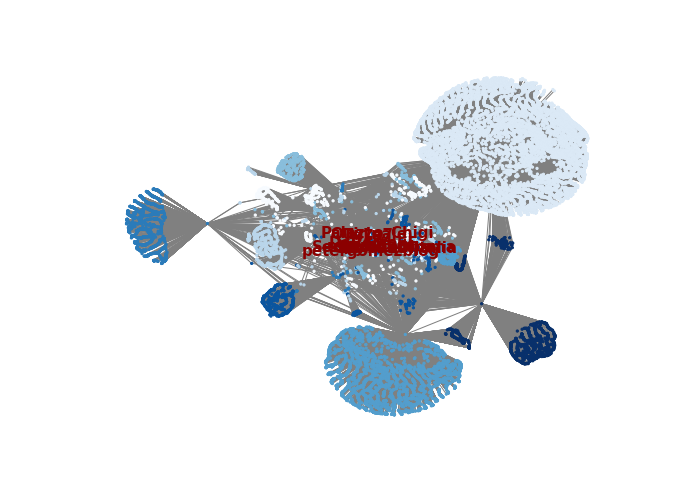

In [62]:
draw_metric(G,deg_C,spring_pos, node_color=values)

**Betweeness Centrality** , differently from Degree Centrality, measures how much a node (a user) acts as a **bridge** between other nodes (other users) and is computed taking into account the number of ***shortest paths*** between a pair of nodes passing from a specific node.  
Since the network we are analyzing is made of people followed by italian politicians, the mean betweeness centrality of the graph is extremely low; of course, the users with the higher betweeness centrality will be those connecting more people, so the top ten nodes according to the metric shouldn't come as a surprise: the leaders themselves.

In [22]:
# betweenness centrality
bC = nx.betweenness_centrality(G)
np.mean(list(bC.values()))

6.734355017477334e-05

In [23]:
sorted(bC.items(), key = lambda v: -v[1])[:10]

[('EnricoLetta', 0.7851155527306274),
 ('civati', 0.3787304682699324),
 ('matteosalvinimi', 0.1382573058358483),
 ('NFratoianni', 0.09133131283123817),
 ('GiorgiaMeloni', 0.05455726973649866),
 ('AngeloBonelli1', 0.044221039375294174),
 ('matteorenzi', 0.04176762367931772),
 ('luigidimaio', 0.017984142864929453),
 ('emmabonino', 0.014136349276754577),
 ('CarloCalenda', 0.004977230467726968)]

Excluding the original list of leaders and visualizing the results we can notice once again that the nodes with the higher betweeness centrality represent journalists, newspapers and the press agency of the italian Senate.

In [24]:
for key in politicians:
    del bC[key]
sorted(bC.items(), key = lambda v: -v[1])[:10]

[('repubblica', 0.0007888008580363124),
 ('SkyTG24', 0.0007888008580363124),
 ('SenatoStampa', 0.0007884356332941725),
 ('agorarai', 0.0007389559040810135),
 ('petergomezblog', 0.0007371594880773808),
 ('Tommasolabate', 0.0007371594880773808),
 ('N_DeGirolamo', 0.0007338433928885604),
 ('DeBortoliF', 0.0007023360234531888),
 ('MassimGiannini', 0.0006953901559835075),
 ('ilpost', 0.0006953901559835075)]

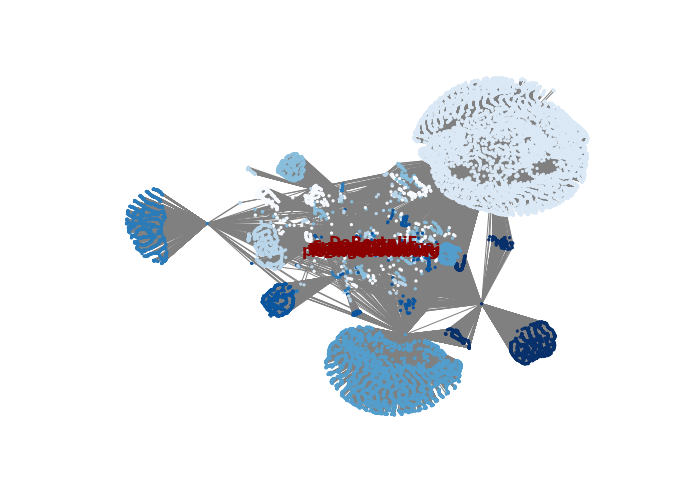

In [64]:
draw_metric(G,bC,spring_pos, node_color=values)

Finally, **Closeness Centrality** quantifies how much a user is close (well connected) to other users: it refers to the average distance of the user from all the other users in the network.  
What is interesting to notice here is that when sorting the users by their closeness centrality we can observe that the higher values, apart from the politcians themselves, is computed for **newspapers** or **journalists** accounts. This is fairly obvious because those will be the accounts which are followed by the most by-partisan audience, from left to right.   

In [26]:
# closeness centrality
clos_C = nx.closeness_centrality(G)
np.mean(list(clos_C.values()))

0.3851363883340345

In [27]:
sorted(clos_C.items(), key = lambda v: -v[1])[:10]

[('EnricoLetta', 0.7052152872926566),
 ('civati', 0.5492212686736594),
 ('GiorgiaMeloni', 0.508256996386251),
 ('NFratoianni', 0.5030464347355944),
 ('repubblica', 0.4987629376108202),
 ('SkyTG24', 0.4987629376108202),
 ('petergomezblog', 0.4972558531521717),
 ('DeBortoliF', 0.49712301179565166),
 ('ferrarailgrasso', 0.4956156525302192),
 ('Avvenire_Nei', 0.49505781234012075)]

Once again, if we exclude the list of original politicians, we end up discovering that the nodes representing the better connected users are all owned by newspapers and journalists.  

What is interesting to notice is that top users according to degree centrality, betweeness centrality and closeness centrality are (with a couple exceptions) ***all from newspapers and journalist***, but ***different ones according to the specific metric***.

In [28]:
for key in politicians:
    del clos_C[key]
sorted(clos_C.items(), key = lambda v: -v[1])[:10]

[('repubblica', 0.4987629376108202),
 ('SkyTG24', 0.4987629376108202),
 ('petergomezblog', 0.4972558531521717),
 ('DeBortoliF', 0.49712301179565166),
 ('ferrarailgrasso', 0.4956156525302192),
 ('Avvenire_Nei', 0.49505781234012075),
 ('DAVIDPARENZO', 0.49505781234012075),
 ('myrtamerlino', 0.49505781234012075),
 ('stanzaselvaggia', 0.49505781234012075),
 ('lucatelese', 0.49505781234012075)]

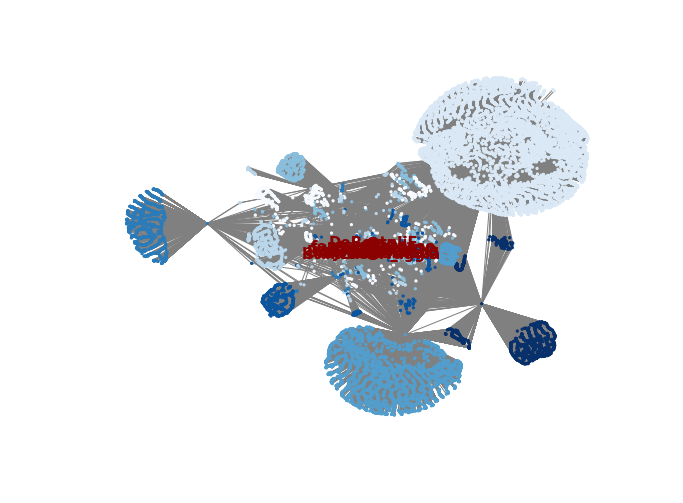

In [65]:
draw_metric(G,clos_C,spring_pos, node_color=values)

## Closing up  

We employed a dataset downloaded via the Twitter API to perform some very basic analytics on the graph generated from the connections of the main political leaders that will be present in September 2022; in particular, we looked at their friends, which are profiles followed by a user. Here, we try to draw some conclusions on the analysis performed.  

* political leader tend to have much more followers than friends: those who have a high number of friends are also the ones that use Twitter more casually, those who tweet the most;
* the ratio between the number of followers and the number of friends can be used to visualize which users are the loudest in terms of both number of tweets and attention on them;
* politicians tend to be connected to each other and to share many connections: most of those shared connections are profiles from other politicians, but also newspapers, journalists and press agencies;
* network topology and network metrics can be used to have a better grasp of what is going on between politicians and their connections. 